# Fermi-LAT data with Gammapy

## Introduction

This tutorial will show you how to work with Fermi-LAT data with Gammapy. As an example, we will look at the Galactic center region using the high-energy dataset that was used for the 3FHL catalog, in the energy range 10 GeV to 2 TeV.

We note that support for Fermi-LAT data analysis in Gammapy is very limited. For most tasks, we recommend you use 
[Fermipy](http://fermipy.readthedocs.io/), which is based on the [Fermi Science Tools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) (Fermi ST).

Using Gammapy with Fermi-LAT data could be an option for you if you want to do an analysis that is not easily possible with Fermipy and the Fermi Science Tools. For example a joint likelihood fit of Fermi-LAT data with data e.g. from H.E.S.S., MAGIC, VERITAS or some other instrument, or analysis of Fermi-LAT data with a complex spatial or spectral model that is not available in Fermipy or the Fermi ST.

Besides Gammapy, you might want to look at are [Sherpa](http://cxc.harvard.edu/sherpa/) or [3ML](https://threeml.readthedocs.io/). Or just using Python to roll your own analyis using several existing analysis packages. E.g. it it possible to use Fermipy and the Fermi ST to evaluate the likelihood on Fermi-LAT data, and Gammapy to evaluate it e.g. for IACT data, and to do a joint likelihood fit using e.g. [iminuit](http://iminuit.readthedocs.io/) or [emcee](http://dfm.io/emcee).

To use Fermi-LAT data with Gammapy, you first have to use the Fermi ST to prepare an event list (using ``gtselect`` and ``gtmktime``, exposure cube (using ``gtexpcube2`` and PSF (using ``gtpsf``). You can then use [gammapy.data.EventList](http://docs.gammapy.org/dev/api/gammapy.data.EventList.html), [gammapy.maps](http://docs.gammapy.org/dev/maps/index.html) and the [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/dev/api/gammapy.irf.EnergyDependentTablePSF.html) to read the Fermi-LAT maps and PSF, i.e. support for these high-level analysis products from the Fermi ST is built in. To do a 3D map analyis, you can use [MapFit](http://docs.gammapy.org/dev/api/gammapy.cube.MapFit.html) for Fermi-LAT data in the same way that it's use for IACT data. This is illustrated in this notebook. A 1D region-based spectral analysis is also possible, this will be illustrated in a future tutorial. There you have to extract 1D counts, exposure and background vectors and then pass them to [SpectrumFit](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html).

## Setup

**IMPORTANT**: For this notebook you have to get the prepared ``3fhl`` dataset provided in the [gammapy-fermi-lat-data](https://github.com/gammapy/gammapy-fermi-lat-data) repository. Please follow the instructions [here](https://github.com/gammapy/gammapy-fermi-lat-data#get-the-data) to download the data and setup your environment.

Note that the ``3fhl`` dataset is high-energy only, ranging from 10 GeV to 2 TeV.

In [1]:
# Check that you have the prepared Fermi-LAT dataset
!ls -1 $GAMMAPY_FERMI_LAT_DATA/3fhl

background_norm
fermi_3fhl_counts_cube_hpx.fits.gz
fermi_3fhl_data_config.yaml
fermi_3fhl_data_prepare.sh
fermi_3fhl_events.fits.gz
fermi_3fhl_events_selected.fits.gz
fermi_3fhl_exposure_cube_hpx.fits.gz
fermi_3fhl_livetime.fits.gz
fermi_3fhl_psf_gc.fits.gz
README.md


In [2]:
# We will use diffuse models from here
!ls -1 $GAMMAPY_EXTRA/datasets/fermi_3fhl

gll_iem_v06_cutout.fits
iso_P8R2_SOURCE_V6_v06.txt
make.py
README.md


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.visualization import simple_norm
from gammapy.data import EventList
from gammapy.irf import EnergyDependentTablePSF
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.spectrum.models import TableModel, PowerLaw, ConstantModel
from gammapy.image.models import SkyPointSource, SkyDiffuseConstant
from gammapy.cube.models import SkyModel, SkyDiffuseCube
from gammapy.cube import MapEvaluator, MapFit, PSFKernel

## Events

To load up the Fermi-LAT event list, use the [gammapy.data.EventList](http://docs.gammapy.org/dev/api/gammapy.data.EventList.html) class:

In [5]:
events = EventList.read('$GAMMAPY_FERMI_LAT_DATA/3fhl/fermi_3fhl_events_selected.fits.gz')
print(events)

EventList info:
- Number of events: 697317
- Median energy: 15895.3505859375 MeV



The event data is stored in a [astropy.table.Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html) object. In case of the Fermi-LAT event list this contains all the additional information on positon, zenith angle, earth azimuth angle, event class, event type etc.

In [6]:
events.table.colnames

['ENERGY',
 'RA',
 'DEC',
 'L',
 'B',
 'THETA',
 'PHI',
 'ZENITH_ANGLE',
 'EARTH_AZIMUTH_ANGLE',
 'TIME',
 'EVENT_ID',
 'RUN_ID',
 'RECON_VERSION',
 'CALIB_VERSION',
 'EVENT_CLASS',
 'EVENT_TYPE',
 'CONVERSION_TYPE',
 'LIVETIME',
 'DIFRSP0',
 'DIFRSP1',
 'DIFRSP2',
 'DIFRSP3',
 'DIFRSP4']

In [7]:
events.table[:5][['ENERGY', 'RA', 'DEC']]

ENERGY,RA,DEC
MeV,deg,deg
float32,float32,float32
12856.5205,139.64438,-9.93702
14773.319,177.04454,60.55275
23273.527,110.21325,37.002018
41866.125,334.85287,17.577398
42463.074,316.86676,48.152477


In [8]:
print(events.time[0].iso)
print(events.time[-1].iso)

2008-08-04 15:49:26.782
2015-07-30 11:00:41.226


In [9]:
events.energy.info('stats')

mean = 28905.451171875 MeV
std = 61051.7421875 MeV
min = 10000.03125 MeV
max = 1998482.75 MeV
n_bad = 0
length = 697317


As a short analysis example we will count the number of events above a certain minimum energy: 

In [10]:
for e_min in [10, 100, 1000] * u.GeV:
    n = (events.energy > e_min).sum()
    print("Events above {0:4.0f}: {1:5.0f}".format(e_min, n))

Events above   10 GeV: 697317
Events above  100 GeV: 23628
Events above 1000 GeV:   544


## Counts

Let us start to prepare things for an 3D map analysis of the Galactic center region with Gammapy. The first thing we do is to define the map geometry. We chose a TAN projection centered on position ``(glon, glat) = (0, 0)`` with pixel size 0.1 deg, and four energy bins.

In [11]:
gc_pos = SkyCoord(0, 0, unit='deg', frame='galactic')
energy_axis = MapAxis.from_edges(
    [10, 30, 100, 300, 2000],
    name='energy', unit='GeV', interp='log',
)
counts = Map.create(
    skydir=gc_pos,
    npix=(100, 80),
    proj='TAN',
    coordsys='GAL',
    binsz=0.1,
    axes=[energy_axis],
)
# We put this call into the same Jupyter cell as the Map.create
# because otherwise we could accidentally fill the counts
# multiple times when executing the ``fill_by_coord`` multiple times.
counts.fill_by_coord({
    'skycoord': events.radec,
    # The coord-based interface doesn't use Quantity,
    # so we need to pass energy in the same unit as
    # used for the map axis
    'energy': events.energy,
})

In [12]:
counts.geom.axes[0]

MapAxis

	name       : energy    
	unit       : 'GeV'     
	nbins      : 4         
	node type  : edge      
	edge min   : 1.0e+01 GeV
	edge max   : 2.0e+03 GeV
	interp     : log       

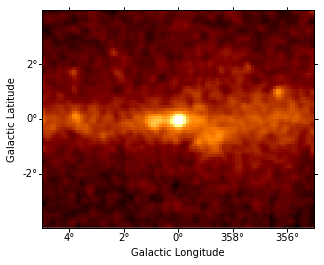

In [13]:
counts.sum_over_axes().smooth(2).plot(stretch='sqrt', vmax=30);

## Exposure

The Fermi-LAT datatset contains the energy-dependent exposure for the whole sky as a HEALPix map computed with ``gtexpcube2``. This format is supported by ``gammapy.maps`` directly.

Interpolating the exposure cube from the Fermi ST to get an exposure cube matching the spatial geometry and energy axis defined above with Gammapy is easy. The only point to watch out for is how exactly you want the energy axis and binning handled.

Below we just use the default behaviour, which is linear interpolation in energy on the original exposure cube. Probably log interpolation would be better, but it doesn't matter much here, because the energy binning is fine. Finally, we just copy the counts map geometry, which contains an energy axis with `node_type="edges"`. This is non-ideal for exposure cubes, but again, acceptable because exposure doesn't vary much from bin to bin, so the exact way interpolation occurs in later use of that exposure cube doesn't matter a lot. Of course you could define any energy axis for your exposure cube that you like.

In [14]:
exposure_hpx = Map.read('$GAMMAPY_FERMI_LAT_DATA/3fhl/fermi_3fhl_exposure_cube_hpx.fits.gz')
# Unit is not stored in the file, set it manually
exposure_hpx.unit = 'cm2 s'
print(exposure_hpx.geom)
print(exposure_hpx.geom.axes[0])

HpxGeom

	axes       : skycoord, energy
	shape      : (12288, 18)
	ndim       : 3
	nside      : 32
	nested     : False
	coordsys   : CEL
	projection : HPX
	center     : 0.0 deg, 0.0 deg

MapAxis

	name       : energy    
	unit       : ''        
	nbins      : 18        
	node type  : center    
	center min : 1.0e+04   
	center max : 2.0e+06   
	interp     : lin       



/home/hfm/adonath/Software/Applications/anaconda3.5/envs/gammapy-dev/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


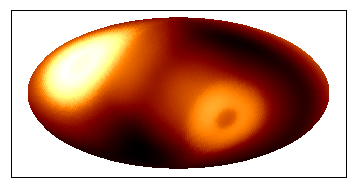

In [15]:
exposure_hpx.plot();

In [16]:
# For exposure, we choose a geometry with node_type='center',
# whereas for counts it was node_type='edge'
axis = MapAxis.from_nodes(counts.geom.axes[0].center,
                          name='energy', unit='GeV', interp='log')
geom = WcsGeom(wcs=counts.geom.wcs, npix=counts.geom.npix, axes=[axis])

coord = counts.geom.get_coord()
data = exposure_hpx.interp_by_coord(coord)
exposure = WcsNDMap(geom, data, unit=exposure_hpx.unit)
print(exposure.geom)
print(exposure.geom.axes[0])

WcsGeom

	axes       : lon, lat, energy
	shape      : (100, 80, 4)
	ndim       : 3
	coordsys   : GAL
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg

MapAxis

	name       : energy    
	unit       : 'GeV'     
	nbins      : 4         
	node type  : center    
	center min : 1.7e+01 GeV
	center max : 7.7e+02 GeV
	interp     : log       



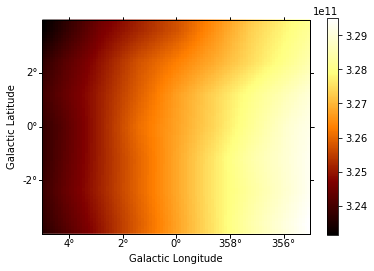

In [17]:
# Exposure is almost constant accross the field of view
exposure.slice_by_idx({'energy': 0}).plot(add_cbar=True);

In [18]:
# Exposure varies very little with energy at these high energies
energy = [10, 100, 1000] * u.GeV
exposure.get_by_coord({
    'skycoord': gc_pos,
    'energy': energy,
})

array([3.26779902e+11, 3.26727081e+11, 3.26523301e+11])

## Galactic diffuse background

The Fermi-LAT collaboration provides a galactic diffuse emission model, that can be used as a background model for
Fermi-LAT source analysis.

Diffuse model maps are very large (100s of MB), so as an example here, we just load one that represents a small cutout for the Galactic center region.

In [19]:
diffuse_galactic_fermi = Map.read('$GAMMAPY_EXTRA/datasets/fermi_3fhl/gll_iem_v06_cutout.fits')
# Unit is not stored in the file, set it manually
diffuse_galactic_fermi.unit = 'cm-2 s-1 MeV-1 sr-1'
print(diffuse_galactic_fermi.geom)
print(diffuse_galactic_fermi.geom.axes[0])

WcsGeom

	axes       : lon, lat, energy
	shape      : (88, 48, 30)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, -0.1 deg
	width      : 11.0 x 6.0 deg

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 30        
	node type  : center    
	center min : 5.8e+01 MeV
	center max : 5.1e+05 MeV
	interp     : lin       



In [20]:
# Interpolate the diffuse emission model onto the counts geometry
# The resolution of `diffuse_galactic_fermi` is low: bin size = 0.5 deg
# We use ``interp=3`` which means cubic spline interpolation
coord = counts.geom.get_coord()

data = diffuse_galactic_fermi.interp_by_coord(
    {'skycoord': coord.skycoord,
     'energy': coord['energy'] * counts.geom.get_axis_by_name('energy').unit},
    interp=3
)
diffuse_galactic = WcsNDMap(exposure.geom, data, unit=diffuse_galactic_fermi.unit)

print(diffuse_galactic.geom)
print(diffuse_galactic.geom.axes[0])

WcsGeom

	axes       : lon, lat, energy
	shape      : (100, 80, 4)
	ndim       : 3
	coordsys   : GAL
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg

MapAxis

	name       : energy    
	unit       : 'GeV'     
	nbins      : 4         
	node type  : center    
	center min : 1.7e+01 GeV
	center max : 7.7e+02 GeV
	interp     : log       



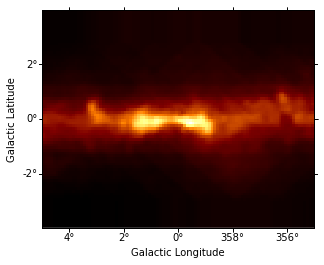

In [21]:
diffuse_galactic.slice_by_idx({'energy': 0}).plot();

Text(0,0.5,'Flux (cm-2 s-1 MeV-1 sr-1)')

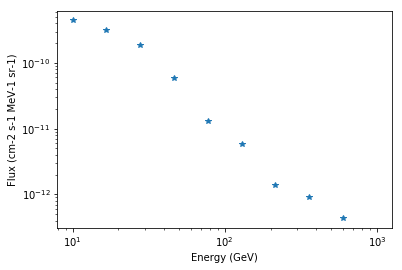

In [22]:
# Exposure varies very little with energy at these high energies
energy = np.logspace(1, 3, 10) * u.GeV
dnde = diffuse_galactic.interp_by_coord({
    'skycoord': gc_pos,
    'energy': energy,
}, interp='linear', fill_value=None)
plt.plot(energy.value, dnde, '*')
plt.loglog()
plt.xlabel('Energy (GeV)')
plt.ylabel('Flux (cm-2 s-1 MeV-1 sr-1)')

In [23]:
# TODO: show how one can fix the extrapolate to high energy
# by computing and padding an extra plane e.g. at 1e3 TeV
# that corresponds to a linear extrapolation

## Isotropic diffuse background

To load the isotropic diffuse model with Gammapy, use the [gammapy.spectrum.models.TableModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.TableModel.html). We are using `'fill_value': 'extrapolate'` to extrapolate the model above 500 GeV:

In [24]:
filename = '$GAMMAPY_FERMI_LAT_DATA/isodiff/iso_P8R2_SOURCE_V6_v06.txt'
interp_kwargs = {'fill_value': 'extrapolate', 'kind': 'cubic'}
diffuse_iso = TableModel.read_fermi_isotropic_model(filename=filename, interp_kwargs=interp_kwargs)

We can plot the model in the energy range between 50 GeV and 2000 GeV:

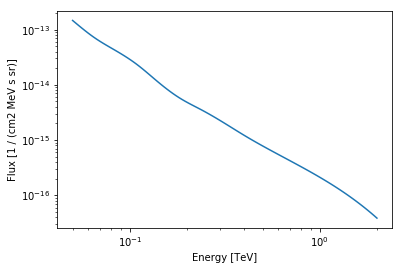

In [25]:
erange = [50, 2000] * u.GeV
diffuse_iso.plot(erange, flux_unit='1 / (cm2 MeV s sr)');

## PSF

Next we will tke a look at the PSF. It was computed using ``gtpsf``, in this case for the Galactic center position. Note that generally for Fermi-LAT, the PSF only varies little within a given regions of the sky, especially at high energies like what we have here. We use the [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/dev/api/gammapy.irf.EnergyDependentTablePSF.html) class to load the PSF and use some of it's methods to get some information about it.

In [26]:
psf = EnergyDependentTablePSF.read('$GAMMAPY_FERMI_LAT_DATA/3fhl/fermi_3fhl_psf_gc.fits.gz')
print(psf)

EnergyDependentTablePSF
-----------------------

Axis info:
  rad            : size =   300, min =  0.000 deg, max =  9.933 deg
  energy         : size =    17, min = 10.000 GeV, max = 2000.000 GeV

Containment info:
  68.0% containment radius at  10 GeV: 0.16 deg
  68.0% containment radius at 100 GeV: 0.10 deg
  95.0% containment radius at  10 GeV: 0.71 deg
  95.0% containment radius at 100 GeV: 0.43 deg



To get an idea of the size of the PSF we check how the containment radii of the Fermi-LAT PSF vari with energy and different containment fractions:

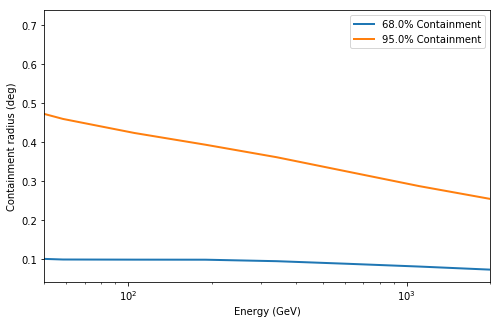

In [27]:
plt.figure(figsize=(8, 5))
psf.plot_containment_vs_energy(linewidth=2, fractions=[0.68, 0.95])
plt.xlim(50, 2000)
plt.show()

In addition we can check how the actual shape of the PSF varies with energy and compare it against the mean PSF between 50 GeV and 2000 GeV:

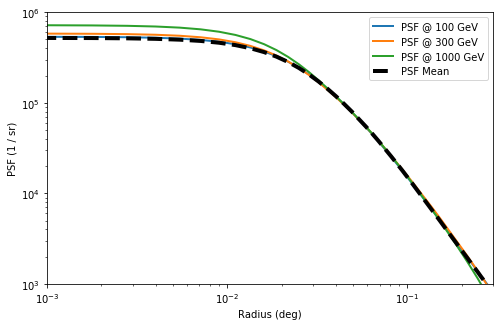

In [28]:
plt.figure(figsize=(8, 5))

for energy in [100, 300, 1000] * u.GeV:
    psf_at_energy = psf.table_psf_at_energy(energy)
    psf_at_energy.plot_psf_vs_rad(label='PSF @ {:.0f}'.format(energy), lw=2)

erange = [50, 2000] * u.GeV
psf_mean = psf.table_psf_in_energy_band(energy_band=erange, spectral_index=2.3)
psf_mean.plot_psf_vs_rad(label='PSF Mean', lw=4, c="k", ls='--')
    
plt.xlim(1e-3, 0.3)
plt.ylim(1e3, 1e6)
plt.legend();

In [29]:
# Let's compute a PSF kernel matching the pixel size of our map
psf_kernel = PSFKernel.from_table_psf(
    psf,
    counts.geom,
    max_radius='0.5 deg',
)

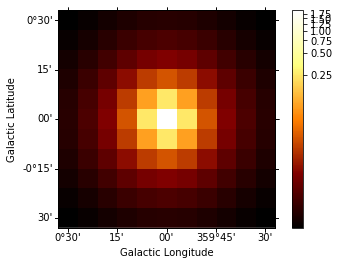

In [30]:
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch='log', add_cbar=True);

## Background

Let's compute a background cube, with predicted number of background events per pixel from the diffuse Galactic and isotropic model components. For this, we use the use the [gammapy.cube.MapEvaluator](http://docs.gammapy.org/dev/api/gammapy.cube.MapEvaluator.html) to multiply with the exposure and apply the PSF. The Fermi-LAT energy dispersion at high energies is small, we neglect it here.

Background counts from Galactic diffuse:  13598.005


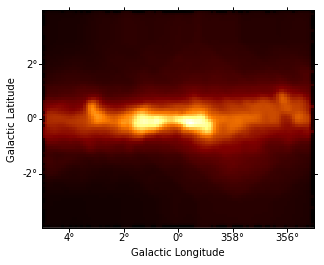

In [31]:
model = SkyDiffuseCube(diffuse_galactic)

evaluator = MapEvaluator(
    model=model,
    exposure=exposure,
    psf=psf_kernel,
)

background_gal = counts.copy(data=evaluator.compute_npred())
background_gal.sum_over_axes().plot()
print('Background counts from Galactic diffuse: ', background_gal.data.sum())

Background counts from isotropic diffuse:  412.01245


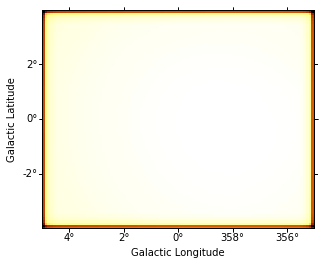

In [32]:
model = SkyModel(SkyDiffuseConstant(), diffuse_iso)

evaluator = MapEvaluator(
    model=model,
    exposure=exposure,
    psf=psf_kernel,
)

background_iso = counts.copy(data=evaluator.compute_npred())
background_iso.sum_over_axes().plot()
print('Background counts from isotropic diffuse: ', background_iso.data.sum())

In [33]:
background = background_gal.copy()
background.data += background_iso.data

## Excess and flux

Let's compute an excess and flux image, by subtracting the background, and summing over the energy axis.

Excess counts:  1605.9819


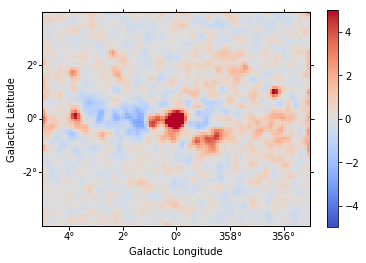

In [34]:
excess = counts.copy()
excess.data -= background.data
excess.sum_over_axes().smooth(2).plot(cmap='coolwarm', vmin=-5, vmax=5, add_cbar=True)
print('Excess counts: ', excess.data.sum())

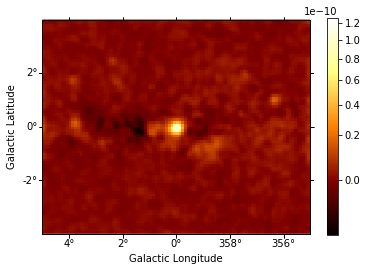

In [35]:
flux = excess.copy()
flux.data /= exposure.data
flux.unit = excess.unit / exposure.unit
flux.sum_over_axes().smooth(2).plot(stretch='sqrt', add_cbar=True);

## Fit

Finally, the big finale: let's do a 3D map fit for the source at the Galactic center, to measure it's position and spectrum.

In [36]:
model = SkyModel(
    SkyPointSource('0 deg', '0 deg'),
    PowerLaw(
        index=2.5,
        amplitude='1e-11 cm-2 s-1 TeV-1',
        reference='100 GeV',
    ),
)
model.parameters.set_parameter_errors({
    'amplitude': '1e-12 cm-2 s-1 TeV-1',
})
fit = MapFit(
    model=model,
    counts=counts,
    exposure=exposure,
    background=background,
    psf=psf_kernel,
)
result = fit.fit()

FCN = 20216.27226299746 
 TOTAL NCALL = 314 
 NCALLS = 314 
 
 
 EDM = 0.00030250054868261533 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_lon_0,-0.0248633,0.00411554,0,0,,,
2,par_001_lat_0,-0.0396965,0.00367384,0,0,,,
3,par_002_index,2.66711,0.0974163,0,0,,,
4,par_003_amplitude,59.7505,9.50826,0,0,,,
5,par_004_reference,1,1,0,0,0.0,,FIXED


## Exercises

- Fit the position and spectrum of the source [SNR G0.9+0.1](http://gamma-sky.net/#/cat/tev/110).
- Make maps and fit the position and spectrum of the [Crab nebula](http://gamma-sky.net/#/cat/tev/25).

## Summary

In this tutorial you have seen how to work with Fermi-LAT data with Gammapy. You have to use the Fermi ST to prepare the exposure cube and PSF, and then you can use Gammapy for any event or map analysis using the same methods that are used to analyse IACT data.

This works very well at high energies (here above 10 GeV), where the exposure and PSF is almost constant spatially and only varies a little with energy. It is not expected to give good results for low-energy data, where the Fermi-LAT PSF is very large. If you are interested to help us validate down to what energy Fermi-LAT analysis with Gammapy works well (e.g. by re-computing results from 3FHL or other published analysis results), or to extend the Gammapy capabilities (e.g. to work with energy-dependent multi-resolution maps and PSF), that would be very welcome!